# Bootstrap Lasso Experiments with Pima Dataset
The goal of this notebook is to experiment with this bootstrap lasso implementation using the same dataset as the R package README.

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import patsy
sns.set_theme()
sns.set_style("whitegrid")

## Prepare Data

In [6]:
# Read data
df = pd.read_csv("../data/pima-data.csv")
# Convert outcome to integer 0,1
df["diabetes"] = df["diabetes"].astype(int)
# Convert names to match R bolasso repo
df = df.rename(columns = {"num_preg": "pregnant",
                     "glucose_conc": "glucose",
                     "diastolic_bp": "pressure",
                     "thickness": "triceps",
                     "bmi": "mass",
                     "diab_pred": "pedigree"})
df.head()

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,1
1,1,85,66,29,0,26.6,0.351,31,1.1426,0
2,8,183,64,0,0,23.3,0.672,32,0.0000,1
3,1,89,66,23,94,28.1,0.167,21,0.9062,0
4,0,137,40,35,168,43.1,2.288,33,1.3790,1


In [7]:
# Split into training and test data
train_idx = np.random.choice(df.index, int(0.7 * df.shape[0]), replace = False) 
train_df = df.iloc[train_idx]
test_df = df.drop(index = train_df.index)

## Define Function

In [8]:
# Define function
def bolasso_parallel(formula, data, n_boot):
    # Create matrices
    df_y, df_X = patsy.dmatrices(formula, data = data)
    # Simple bootstrap
    n_rows = df_X.shape[0]
    n_cols = df_X.shape[1]
    # Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
    bs_results = np.empty(shape = (n_boot, n_cols))
    # Define inner function for passing to parallel
    # Convert to numpy array to fix issue with parallelization pickling
    X = np.asarray(df_X)
    y = np.asarray(df_y).ravel()
    def inner_func(i):
         # Randomly sample row indices with replacement
        idx = np.random.randint(0, n_rows-1, n_rows)
        # Fit Lasso regression on sampled rows with CV Lambda
         # df_X has a column of 1's from patsy, so we don't need  LassoCV to add its own intercept
        reg = LassoCV(cv = 5, random_state = 0, fit_intercept = False).fit(X[idx,], y[idx,])
        # Store coefficients
        return reg.coef_
    bs_results = Parallel(n_jobs = -2)(delayed(inner_func)(i) for i in range(n_boot))
    bs_results = np.array(bs_results)
    # Parse inclusion probabilities output into dataframe
    vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
    # Parse coefficients output into dataframe
    coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
    return vip_df, coef_df
    

## Run model

In [9]:
# Run model
formula = "diabetes ~ " + " + ".join(train_df.columns.difference(["diabetes"]))
vip_df, coef_df = bolasso_parallel(formula = formula,
                                   data = train_df,
                                   n_boot = 100)

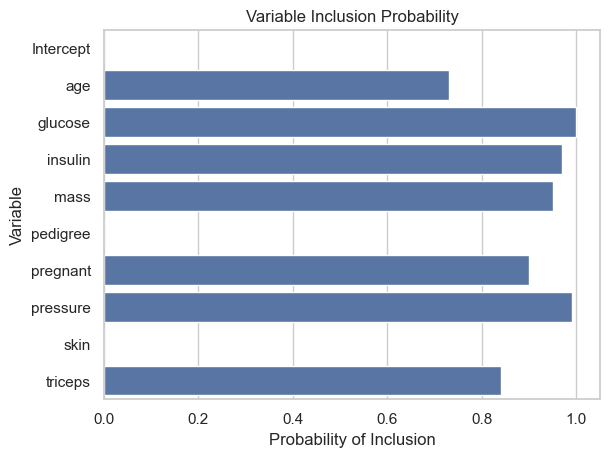

In [10]:
g = sns.barplot(x = "probability", 
                y = "variable", 
                data = vip_df)
g.set(title = "Variable Inclusion Probability",
      xlabel = "Probability of Inclusion",
      ylabel = "Variable")
plt.show()

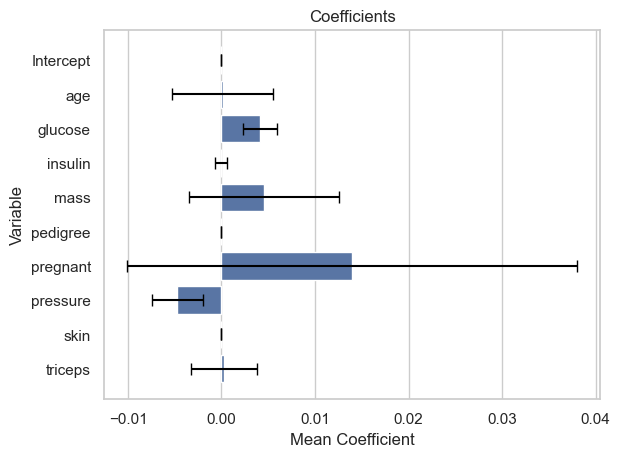

In [11]:
g = sns.barplot(x = "mean_coef", 
                y = "variable", 
                data = coef_df)
g.errorbar(x = coef_df["mean_coef"], 
           y = coef_df["variable"], 
           xerr = coef_df["p_95"] - coef_df["p_05"], 
           fmt = "none",
           color = "black",
           capsize = 4)
g.set(title = "Coefficients",
      xlabel = "Mean Coefficient",
      ylabel = "Variable")
plt.show()

**Issue: sklearn's LassoCV only has the least squares penalty plus the L1 penalty. It does not support binomial or poisson dependent variables.**

## Experiment: Use LogisticRegressionCV with L1 penalty

In [12]:
# Define function
def bolasso_parallel_logistic(formula, data, n_boot):
    # Create matrices
    df_y, df_X = patsy.dmatrices(formula, data = data)
    # Simple bootstrap
    n_rows = df_X.shape[0]
    n_cols = df_X.shape[1]
    # Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
    bs_results = np.empty(shape = (n_boot, n_cols))
    # Define inner function for passing to parallel
    # Convert to numpy array to fix issue with parallelization pickling
    X = np.asarray(df_X)
    y = np.asarray(df_y).ravel()
    def inner_func(i):
         # Randomly sample row indices with replacement
        idx = np.random.randint(0, n_rows-1, n_rows)
        # Fit Lasso regression on sampled rows with CV Lambda
         # df_X has a column of 1's from patsy, so we don't need  LassoCV to add its own intercept
        #reg = LassoCV(cv = 5, random_state = 0, fit_intercept = False).fit(X[idx,], y[idx,])
        reg = LogisticRegressionCV(cv = 5, random_state = 0, fit_intercept = False, penalty = "l1", solver = "liblinear", max_iter=1000).fit(X[idx,], y[idx,])
        # Store coefficients
        return reg.coef_.ravel()
    bs_results = Parallel(n_jobs = -2)(delayed(inner_func)(i) for i in range(n_boot))
    bs_results = np.array(bs_results)
    # Parse inclusion probabilities output into dataframe
    vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
    # Parse coefficients output into dataframe
    coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
    # Format full results
    full_results_df = pd.DataFrame(bs_results, columns = df_X.design_info.column_names)
    return vip_df, coef_df, full_results_df
    

In [13]:
# Run model
formula = "diabetes ~ " + " + ".join(train_df.columns.difference(["diabetes"]))
vip_df, coef_df, full_results_df = bolasso_parallel_logistic(formula = formula,
                                   data = train_df,
                                   n_boot = 100)

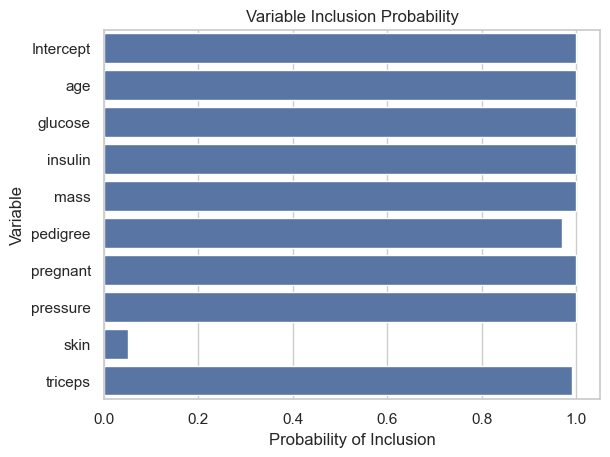

In [14]:
g = sns.barplot(x = "probability", 
                y = "variable", 
                data = vip_df)
g.set(title = "Variable Inclusion Probability",
      xlabel = "Probability of Inclusion",
      ylabel = "Variable")
plt.show()

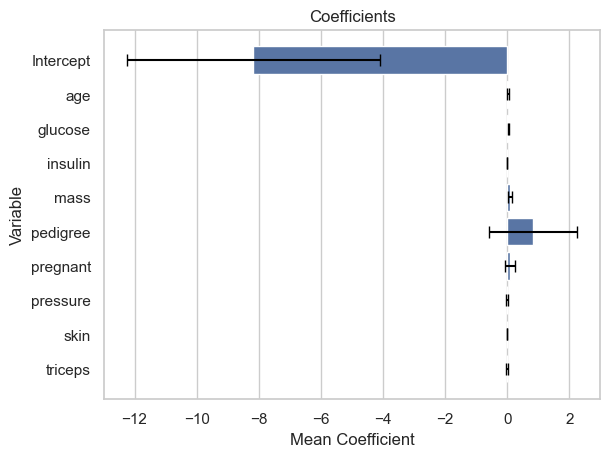

In [15]:
g = sns.barplot(x = "mean_coef", 
                y = "variable", 
                data = coef_df)
g.errorbar(x = coef_df["mean_coef"], 
           y = coef_df["variable"], 
           xerr = coef_df["p_95"] - coef_df["p_05"], 
           fmt = "none",
           color = "black",
           capsize = 4)
g.set(title = "Coefficients",
      xlabel = "Mean Coefficient",
      ylabel = "Variable")
plt.show()

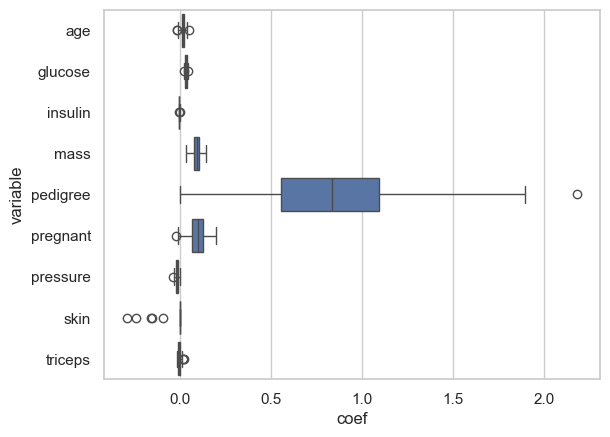

In [16]:
plot_df = full_results_df.melt(value_name="coef")
plot_df = plot_df[plot_df["variable"] != "Intercept"]
g = sns.boxplot(x = "coef", 
                y = "variable", 
                data = plot_df)
plt.show()

## Handle multiple outcome distributions

In [17]:
# Define function
def bolasso(formula, data, family = "gausian", n_boot = 100):
    if family not in ["gaussian", "binomial"]:
        raise Exception("family " + family + " not supported.")
    # Create matrices
    df_y, df_X = patsy.dmatrices(formula, data = data)
    # Simple bootstrap
    n_rows = df_X.shape[0]
    n_cols = df_X.shape[1]
    # Empty matrix to store coefficients; each row will be a bootstrap outcome, each column a variable
    bs_results = np.empty(shape = (n_boot, n_cols))
    # Define inner function for passing to parallel
    # Convert to numpy array to fix issue with parallelization pickling
    X = np.asarray(df_X)
    y = np.asarray(df_y).ravel()
    def inner_func(i):
         # Randomly sample row indices with replacement
        idx = np.random.randint(0, n_rows-1, n_rows)
        # Fit Lasso regression on sampled rows with CV Lambda
        # df_X has a column of 1's from patsy, so we don't need to fit another intercept
        if family == "gaussian":
            reg = LassoCV(cv = 5, random_state = 0, fit_intercept = False).fit(X[idx,], y[idx,])
        elif family == "binomial":
            reg = LogisticRegressionCV(cv = 5, random_state = 0, fit_intercept = False, penalty = "l1", solver = "liblinear", max_iter=1000).fit(X[idx,], y[idx,])
        # Store coefficients
        return reg.coef_.ravel()
    bs_results = Parallel(n_jobs = -2)(delayed(inner_func)(i) for i in range(n_boot))
    bs_results = np.array(bs_results)
    # Parse inclusion probabilities output into dataframe
    vip_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "probability": (abs(bs_results) > 0).mean(axis = 0)})
    # Parse coefficients output into dataframe
    coef_df = pd.DataFrame({"variable": df_X.design_info.column_names, 
                       "mean_coef": bs_results.mean(axis = 0),
                       "p_05": np.percentile(bs_results, q = 5, axis = 0),
                       "p_95": np.percentile(bs_results, q = 95, axis = 0)})
    # Format full results
    full_results_df = pd.DataFrame(bs_results, columns = df_X.design_info.column_names)
    return vip_df, coef_df, full_results_df

In [18]:
# Run model
formula = "diabetes ~ " + " + ".join(train_df.columns.difference(["diabetes"]))
g_vip_df, g_coef_df, g_full_results_df = bolasso(formula = formula,
                                   data = train_df,
                                   family = "gaussian",
                                   n_boot = 100)

In [22]:
b_vip_df, b_coef_df, b_full_results_df = bolasso(formula = formula,
                                   data = train_df,
                                   family = "binomial",
                                   n_boot = 100)

In [24]:
b_coef_df

,variable,mean_coef,p_05,p_95
0,Intercept,-8.153293,-9.894355,-6.140757
1,age,0.017597,-0.006004,0.038220
2,glucose,0.035865,0.027414,0.046615
3,insulin,-0.001712,-0.003527,0.000060
4,mass,0.087752,0.054765,0.116902
5,pedigree,0.791636,0.021618,1.558415
6,pregnant,0.100795,0.039846,0.167742
7,pressure,-0.015181,-0.025784,-0.004742
8,skin,-0.010078,-0.086207,0.000000
9,triceps,-0.000829,-0.014347,0.012616
